# Hidden Markov Model - Morning Insanity

In this notebook, we present an example of (im-)practical application of the Hidden Markov Model.

Picture the following scenario:
It's at 7 a.m. You're preparing to go to work.
In practice, it means that you are running like crazy between different rooms.
You spend some random amount of time in each, doing something,
hoping to get everything you need to be sorted before you leave.
Sounds familiar?

To make things worse, your girlfriend has a cat.
The little furball wants to eat.
Due to the morning hustle, it is uncertain whether you would remember to feed it.
If you don't, the cat will be upset... and so will your girlfriend if she finds out.

## Modeling the situation
Say your flat has four rooms. That is to include the kitchen, bathroom, living room and bedroom.
You spend some random amount of time in each, and transition between the rooms with a certain probability.
At the same time, where ever you go, you are likely to make some distinct kinds of noises.
Your girlfriend hears these noises and, despite being still asleep, she can infer in which room you are spending your time.

And so she does that day by day.
She wants to make sure that you do feed the cat.

However, since she can't be there, all she can do is to place the cat food bag in a room where you supposedly stay the longest.
Hopefully, that will increase the chances that you do feed the "beast" (and save your evening).

### Markovian view
From the Markovian perspective the $N$ rooms (four in our case) are the hidden states $Q = \{q_1, q_2, ..., q_N\}$.
Every minute (or any other time constant), we transition from one room to another $q_i^{(t)} \to q_j^{(t + 1)}$.
The probabilities associated with the transitioning are the elements of $A$ matrix ($a_{i,j}$).

At the same time, there exist $M$ distinct observables $\mathcal{O}$ your girfriend can hear:
* __flushing toilet__ (most likely: bathroom),
* __toothbrushing sound__ (most likely: bathroom),
* __coffee machine__ (most likely: kitchen),
* __opening the fridge__ (most likely: kitchen),
* __TV commercials__ (most likely: living room),
* __music on a radio__ (most likely: kitchen),
* __washing dishes__ (most likely: kitchen),
* __taking a shower__ (most likely bathroom,
* __opening/closing a wardrobe__ (most likely: bedroom),
* __ackward silence__...

The probabilities of their occurrence given a _state_ $q_j^{(t)}$ is given by $b_{j}(k)$ coefficients of the matrix $B$.
In principle, any of these could originate from you being in an arbitrary room (state).
In practice, however, there is physically little chance you have raised the toilet flap while being in the kitchen, thus some $b$'s will be close to zero.

Most importantly, as you hop from one room to the other, it reasonable to assume that whichever room you go to depends only on the room that you have just been to.
In other words, the state at time $t$ depends on the state at time $t - 1$ only.


## Uncovering the hidden states

### The goal
For the first attempt, let's assume that the probability coefficients are **known.**
This means that we have a model $\lambda = (\mathbf{A}, \mathbf{B}, \vec{\pi})$,
and our task is to estimate the latent sequence $X = (x_1, x_2, ..., x_{T}), x_t = q_j^{(t)}$ given the observation sequence $p(X|\mathcal{O},\lambda)$.
In other words, the girlfriend wants to establish in what room do we spend the most time, given what she hears.

### Initialization

In [1]:
%pylab inline
import pandas as pd
import numpy as np

from definitions import ProbabilityVector as PV
from definitions import ProbabilityMatrix as PM
from chains import HiddenMarkovLayer
from models import HiddenMarkovModel

np.random.seed(3)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Transition Matrix
A = PM({
    'bathroom':    PV({'bathroom': 0.90, 'bedroom': 0.08, 'kitchen': 0.01, 'living room': 0.01}),
    'bedroom':     PV({'bathroom': 0.01, 'bedroom': 0.90, 'kitchen': 0.05, 'living room': 0.04}),
    'living room': PV({'bathroom': 0.05, 'bedroom': 0.02, 'kitchen': 0.23, 'living room': 0.70}),
    'kitchen':     PV({'bathroom': 0.03, 'bedroom': 0.02, 'kitchen': 0.85, 'living room': 0.10})
})
A.df

,bathroom,bedroom,kitchen,living room
bathroom,0.90,0.08,0.01,0.01
bedroom,0.01,0.90,0.05,0.04
kitchen,0.03,0.02,0.85,0.10
living room,0.05,0.02,0.23,0.70


In [3]:
B = PM({
    'bathroom': PV({
        'flushing':   0.20,
        'toothbrush': 0.40,
        'coffee':     0.01,
        'television': 0.01,
        'radio':      0.01,
        'dishes':     0.01,
        'shower':     0.30,
        'wardrobe':   0.01,
        'silence':    0.05
    }),
    'bedroom': PV({
        'flushing':   0.01,
        'toothbrush': 0.01,
        'coffee':     0.01,
        'television': 0.05,
        'radio':      0.10,
        'dishes':     0.01,
        'shower':     0.01,
        'wardrobe':   0.50,
        'silence':    0.30
    }),
    'kitchen': PV({
        'flushing':   0.01,
        'toothbrush': 0.02,
        'coffee':     0.30,
        'television': 0.05,
        'radio':      0.10,
        'dishes':     0.20,
        'shower':     0.01,
        'wardrobe':   0.01,
        'silence':    0.30
    }),
    'living room': PV({
        'flushing':   0.01,
        'toothbrush': 0.01,
        'coffee':     0.02,
        'television': 0.30,
        'radio':      0.10,
        'dishes':     0.01,
        'shower':     0.01,
        'wardrobe':   0.02,
        'silence':    0.30
    })
})
B.df

,coffee,dishes,flushing,radio,shower,silence,television,toothbrush,wardrobe
bathroom,0.010000,0.010000,0.200000,0.010000,0.300000,0.050000,0.010000,0.400000,0.010000
bedroom,0.010000,0.010000,0.010000,0.100000,0.010000,0.300000,0.050000,0.010000,0.500000
kitchen,0.300000,0.200000,0.010000,0.100000,0.010000,0.300000,0.050000,0.020000,0.010000
living room,0.025641,0.012821,0.012821,0.128205,0.012821,0.384615,0.384615,0.012821,0.025641


In [4]:
pi = PV({'bathroom': 0.00, 'bedroom': 1.00, 'kitchen': 0.00, 'living room': 0.00})
pi.df.to_markdown()

'|             |   bathroom |   bedroom |   kitchen |   living room |\n|:------------|-----------:|----------:|----------:|--------------:|\n| probability |          0 |         1 |         0 |             0 |'

In [5]:
hml = HiddenMarkovLayer(A, B, pi)
hmm = HiddenMarkovModel(hml)

### Simulation
Having defined $A, B$ and $\pi$, let's see how a typical "morning insanity" might look like.
Here, we assume that the whole "circus" lasts 30 minutes, with one-minute granularity.

In [6]:
observations, latent_states = hml.run(30)
print(pd.DataFrame({'noise': observations, 'room': latent_states}).head(10).to_markdown())

|    | noise      | room     |
|---:|:-----------|:---------|
|  0 | wardrobe   | bedroom  |
|  1 | television | bedroom  |
|  2 | wardrobe   | kitchen  |
|  3 | shower     | bedroom  |
|  4 | silence    | bedroom  |
|  5 | silence    | bathroom |
|  6 | shower     | kitchen  |
|  7 | silence    | kitchen  |
|  8 | silence    | bathroom |
|  9 | silence    | bedroom  |


The table above shows the first ten minutes of the sequence.
We can see that it kind of makes sense, although we have to note that the girlfriend does not know what room we visited.
This sequence is hidden from her.

However, as it is presented in the previous notebooks, we can _guess_ what would be the statistically most favorable sequence of the rooms given the observations.
This corresponds to the problem #2, which we addressed with the `.uncover` method.

In [7]:
estimated_states = hml.uncover(observations)
df = pd.DataFrame({'estimated': estimated_states, 'real': latent_states})
print(df.head(10).to_markdown())

|    | estimated   | real     |
|---:|:------------|:---------|
|  0 | bedroom     | bedroom  |
|  1 | bedroom     | bedroom  |
|  2 | bedroom     | kitchen  |
|  3 | bedroom     | bedroom  |
|  4 | bedroom     | bedroom  |
|  5 | bedroom     | bathroom |
|  6 | bedroom     | kitchen  |
|  7 | living room | kitchen  |
|  8 | living room | bathroom |
|  9 | living room | bedroom  |


In [8]:
print("Matching elements:", df.apply(lambda x: x['estimated'] == x['real'], axis=1).sum(), '\n')

print("Estimated time proportion.\n", df['estimated'].value_counts(), '\n')
print("Real time proportion.\n", df['real'].value_counts(), '\n')

Matching elements: 12 

Estimated time proportion.
 bedroom        18
living room     8
kitchen         4
bathroom        1
Name: estimated, dtype: int64 

Real time proportion.
 bedroom        17
kitchen        10
bathroom        2
living room     2
Name: real, dtype: int64 



The resulting estimate gives 12 correct matches.
Although this may seem like not much (only ~40% accuracy), it is 1.6 times better than a random guess.

Furthermore, we are not interested in matching the elements of the sequences here anyway.
What interests us more is to find the room that you spend the most amount of time in.
According to the simulation, you spend as much as 17 minutes in the bedroom.
This estimate is off by one minute from the real sequence, which translates to ~6% relative error.
Not that bad.

According to these results, the cat food station should be placed in the bedroom.

## Training the model
In the last section, we have, relied on an assumption that the intrinsic probabilities of transition and observation are **known.**
In other words, your girlfriend must have been watching your pretty closely, essentially collecting data about you.
Otherwise, how else would she be able for formulate a model?

Although this may sound like total insanity, the good news is that our model is also **trainable.**
Given a sequence of observations, it is possible to train the model and then use it to examine the hidden variables.

Let's take an example sequence of what your girlfriend could have heard some crazy Monday morning.
You woke up.
Being completely silent for about 3 minutes, you went about to look for your socks in a wardrobe.
Having found what you needed (or not), you went silent again for five minutes and flushed the toilet. Immediately after, you proceeded to take a shower (5 minutes), followed by brushing your teeth (3 minutes), although you turn the radio on in between.
Once you were done, you turned the coffee machine on, watched TV (3 minutes), and did the dishes.

So, the observable sequence goes as follows:

In [9]:
what_she_heard = ['silence']*3 \
+ ['wardrobe'] \
+ ['silence']*5 \
+ ['flushing'] \
+ ['shower']*5 \
+ ['radio']*2 \
+ ['toothbrush']*3 \
+ ['coffee'] \
+ ['television']*3 \
+ ['dishes']

rooms = ['bathroom', 'bedroom', 'kitchen', 'living room']
pi = PV({'bathroom': 0, 'bedroom': 1, 'kitchen': 0, 'living room': 0}) 

The starting point is the _bedroom_, but $A$ and $B$ are unknown.
Let's initialize the model, and train it on the observation sequence.

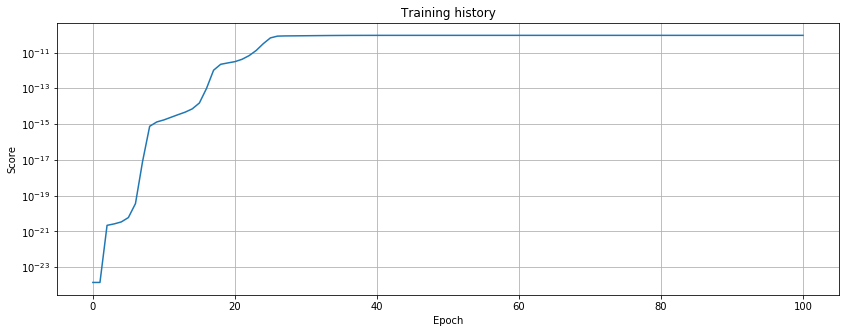

In [10]:
np.random.seed(3)

model = HiddenMarkovModel.initialize(rooms, list(set(what_she_heard)))
model.layer.pi = pi
model.train(what_she_heard, epochs=100)

fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.semilogy(model.score_history)
ax.set_xlabel('Epoch')
ax.set_ylabel('Score')
ax.set_title('Training history')
plt.grid()
plt.show()

In [11]:
model.layer.T.df

,bathroom,bedroom,kitchen,living room
bathroom,0.833333,0.000000,0.166667,0.0
bedroom,0.111111,0.888889,0.000000,0.0
kitchen,0.000000,0.000000,0.500000,0.5
living room,0.000000,0.000000,0.000000,1.0


In [12]:
model.layer.E.df

,coffee,dishes,flushing,radio,shower,silence,television,toothbrush,wardrobe
bathroom,0.000,0.000,1.666667e-01,1.491316e-46,8.333333e-01,2.013549e-75,0.000,0.000000e+00,0.000000
bedroom,0.000,0.000,6.507184e-16,0.000000e+00,0.000000e+00,8.888889e-01,0.000,0.000000e+00,0.111111
kitchen,0.000,0.000,0.000000e+00,1.000000e+00,6.577464e-41,0.000000e+00,0.000,4.884811e-14,0.000000
living room,0.125,0.125,0.000000e+00,1.418634e-49,0.000000e+00,0.000000e+00,0.375,3.750000e-01,0.000000


In [13]:
from itertools import groupby

df = pd.DataFrame(zip(what_she_heard, model.layer.uncover(what_she_heard)), columns=['sounds', 'guess'])
df

,sounds,guess
0,silence,bedroom
1,silence,bedroom
2,silence,bedroom
3,wardrobe,bedroom
4,silence,bedroom
5,silence,bedroom
6,silence,bedroom
7,silence,bedroom
8,silence,bedroom
9,flushing,bathroom


In [14]:
df.groupby('guess').count().rename(columns={'sounds': 'time'})

,time
guess,
bathroom,6
bedroom,9
kitchen,2
living room,8


According to the table above, it is evident that the cat food should be placed in the bedroom.

However, it is important to note that this result is somewhat a nice coincidence because the model was initialized from a purely random state.
Consequently, we had no control over the direction it would evolve in the context of the labels.
In other words, the naming for the hidden states is purely our convention.
The model could just as well associate "shower" with a "kitchen" and "coffee" with "bathroom", in which case
we should examine the labels and swap them if necessary.

Still, in our case, the model seems to have trained to output something fairly reasonable.

## Conclusion
Hopefully, we have shed a bit of light into this whole story of morning insanity using the Hidden Markov model approach.

We have presented two cases.
The first case assumed that the probability coefficients were known.
Using these coefficients, we could define the model and uncover the latent state sequence given the observation sequence.
The second case represented the opposite situation.
The probabilities were not known and so the model had to be trained first in order to output the hidden sequence.

### Closing remark
The situation described here is a real situation that the author faces every day ;)